# Make Bipedal Robot Walk

In [67]:
import numpy as np
import gym

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display
%matplotlib inline

np.random.seed(1)

In [2]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    From http://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [3]:
ENV = gym.make('BipedalWalker-v2')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [4]:
print(ENV.observation_space, ENV.action_space)

Box(24,) Box(4,)


In [5]:
print(ENV.observation_space.low, ENV.observation_space.high)
print(ENV.action_space.low, ENV.action_space.high)

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf]
[-1. -1. -1. -1.] [1. 1. 1. 1.]


Looks like our observations are unbounded. Too bad - this way we can't squeeze it into [0, 1]. Once we collect some data, we'll try to standardize the input to mean 0, standard deviation 1.

Outputs are bounded in [-1, 1]. We'll use a tanh activation function to squeeze our answers into this range.

Let's try a fully connected shallow network (0 hidden layers). Basically a logistic regression, except the activation is tanh.

In [66]:
class Base_Policy():
    
    def __init__(self, env = ENV):
        self.env = env
        self.nS = env.observation_space.shape[0]
        self.nA = env.action_space.shape[0]
        self.W = np.random.rand(self.nA, self.nS)  # Out dim is 0 to avoid transposes later
        self.n = 0
    
    def pi(self, state, W = None):
        if W is None: W = self.W 
        return np.tanh(W @ state)
    
    def playPol(self, W = None, save_frames = False):
        self.s = self.env.reset()
        frames = []
        reward = 0
        for i in range(2000):
            if save_frames: frames.append(self.env.render(mode = 'rgb_array'))
            self.call_before_action()
            action = self.pi(self.s, W)
            self.s, self.r, self.done, _ = self.env.step(action)
            reward += self.r
            self.n += 1
            if self.done: break
        if save_frames: self.env.close()
        return (reward, frames)
    
    def sample_deltas(self, num):
        return [np.random.randn(*self.W.shape) for _ in range(num)]
    
    def call_before_action(self):
        pass

In [19]:
base_pol = Base_Policy()

In [112]:
def illustrate(pol):
    reward, frames = pol.playPol(save_frames = True)
    print(f'Total reward: {reward}')
    display_frames_as_gif(frames)

Total reward: -116.0732675607523



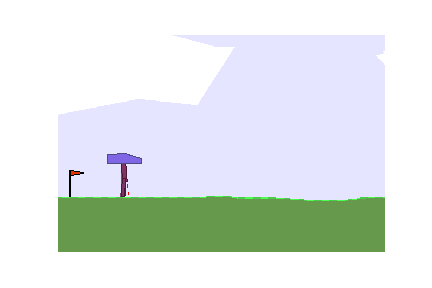
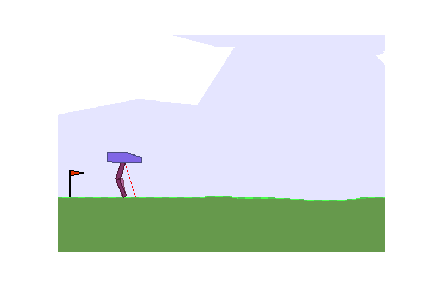
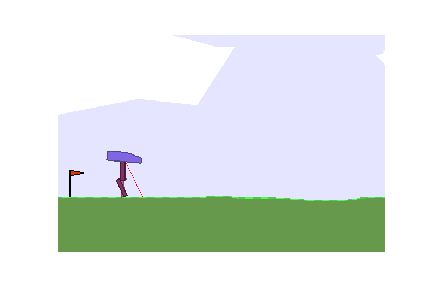
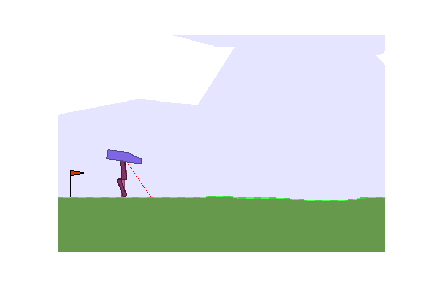
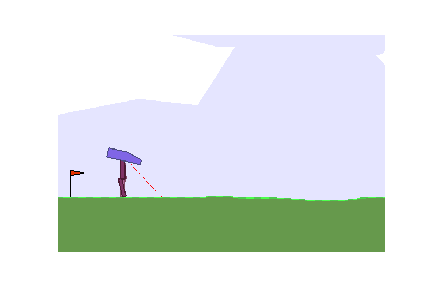
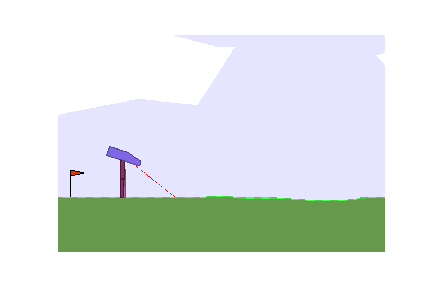
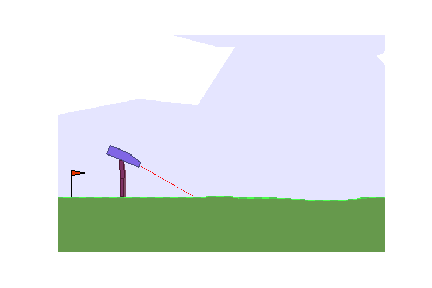
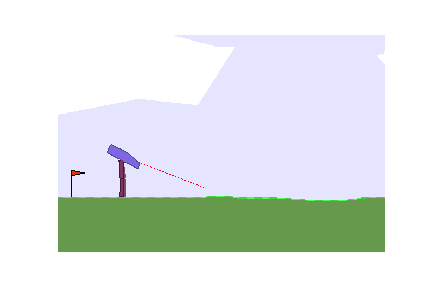
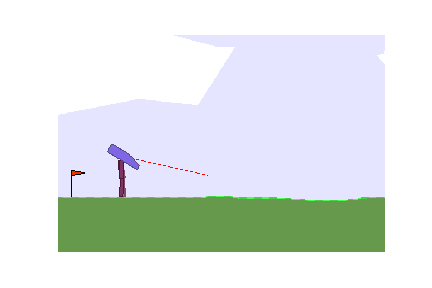
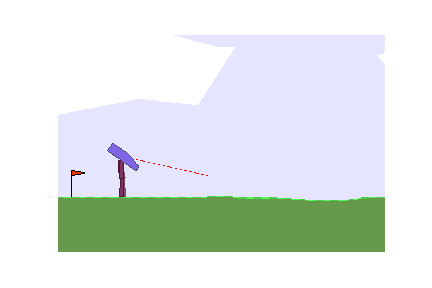
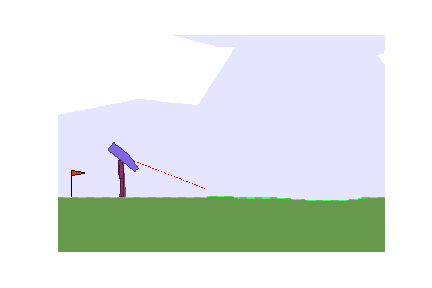
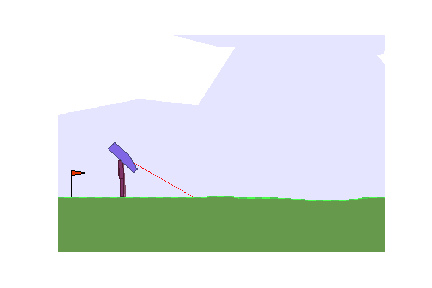
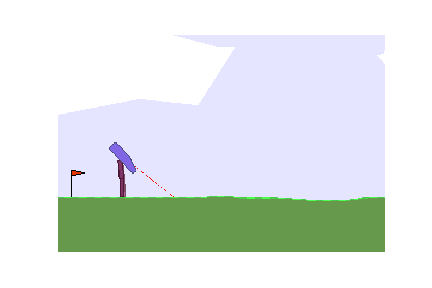
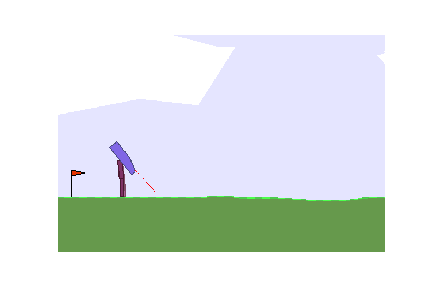
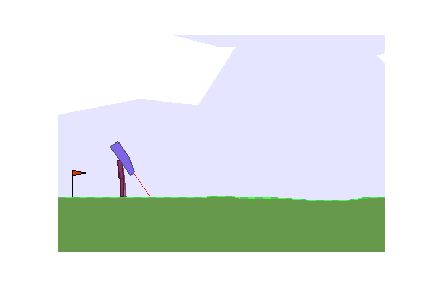
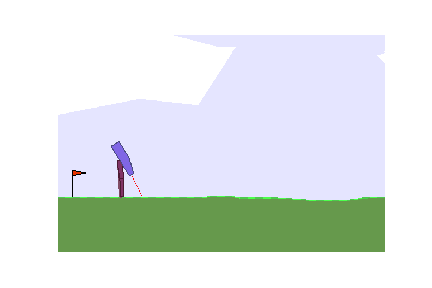
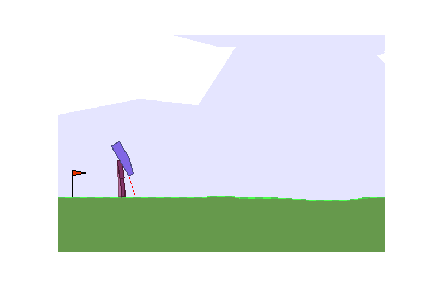
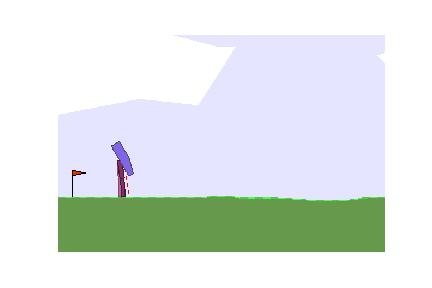
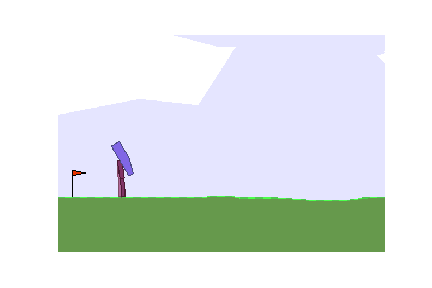
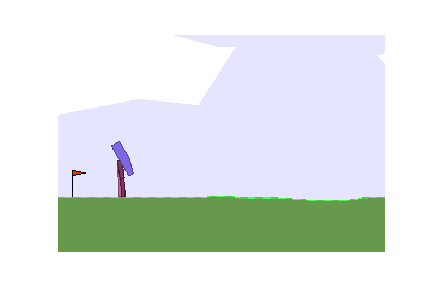
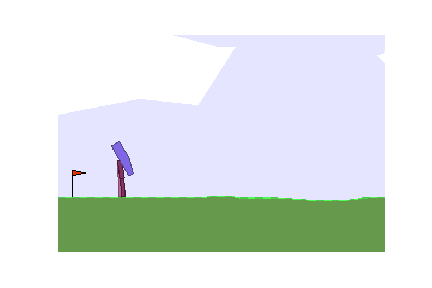
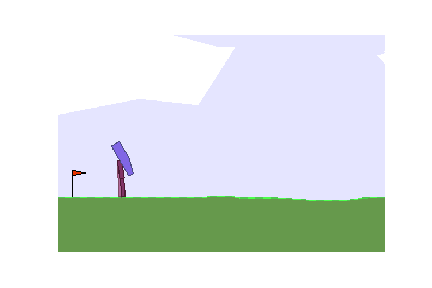
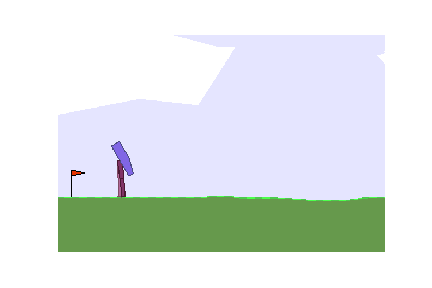
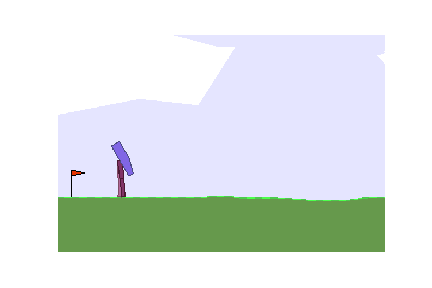
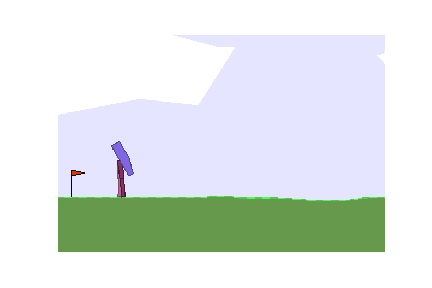
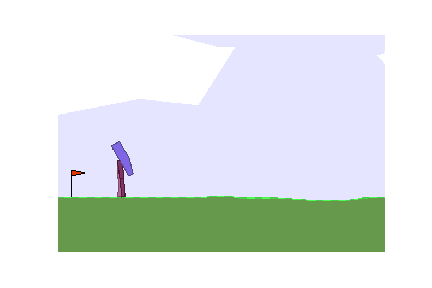
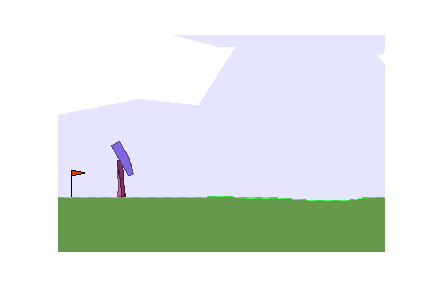
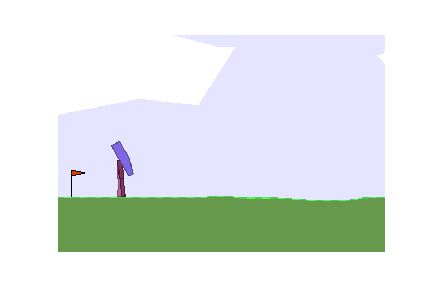
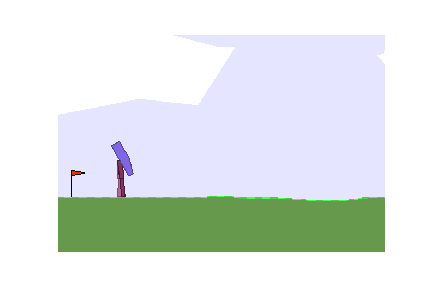
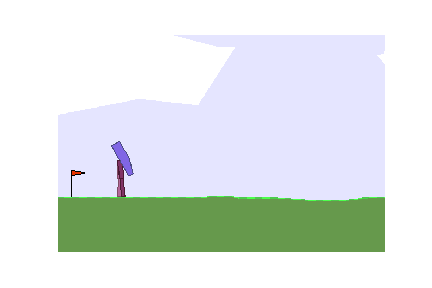
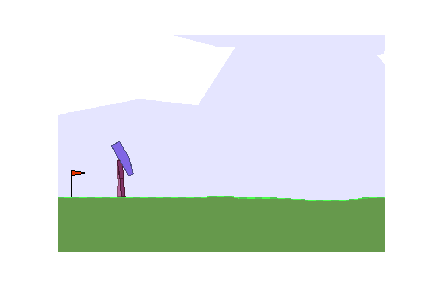
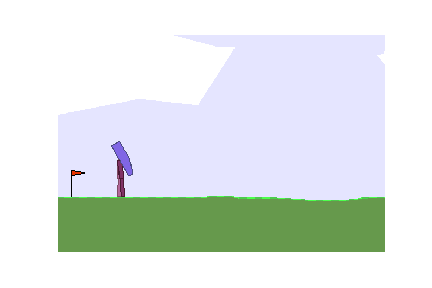
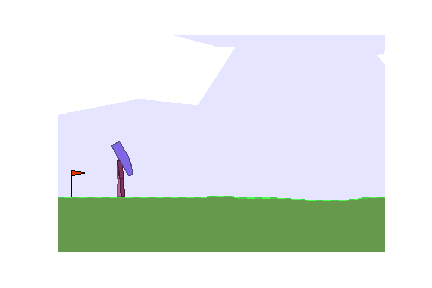
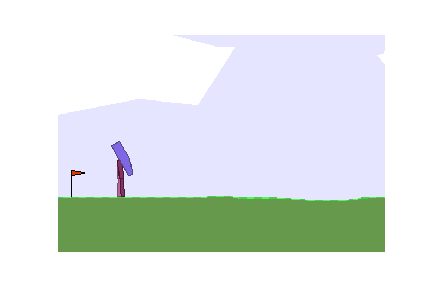
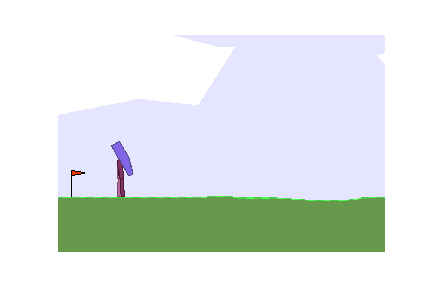
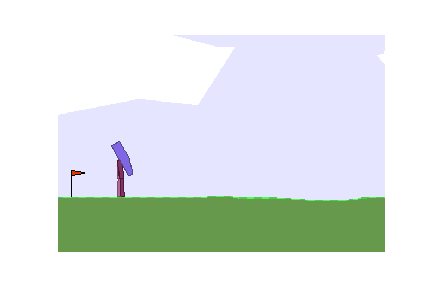
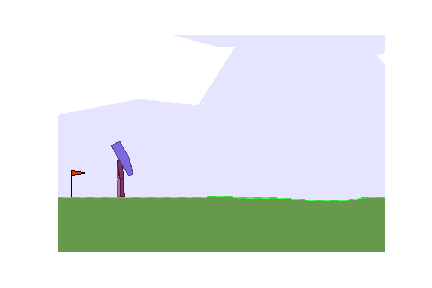
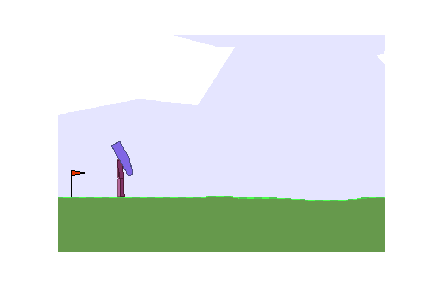
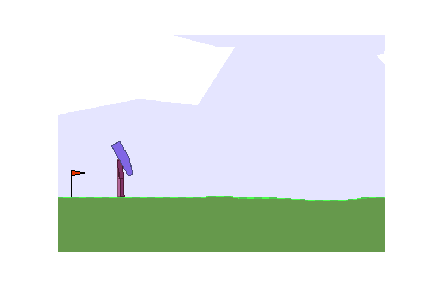
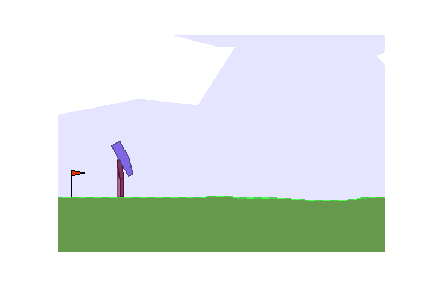
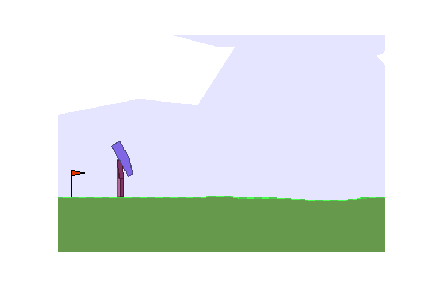
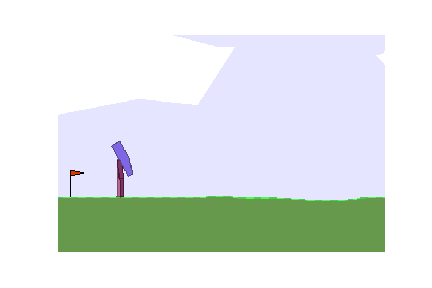
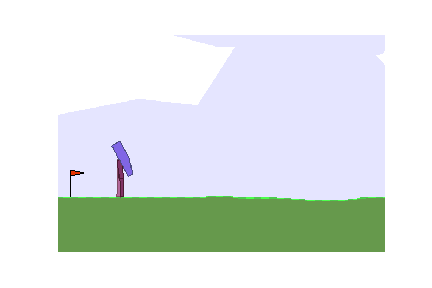
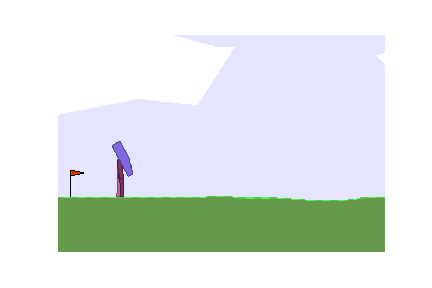
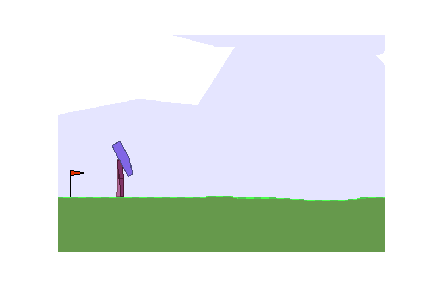
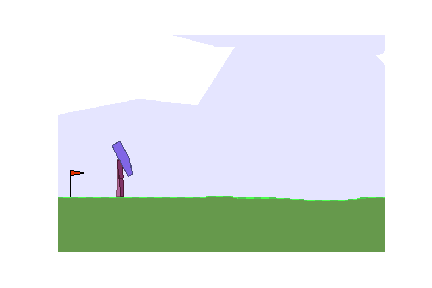
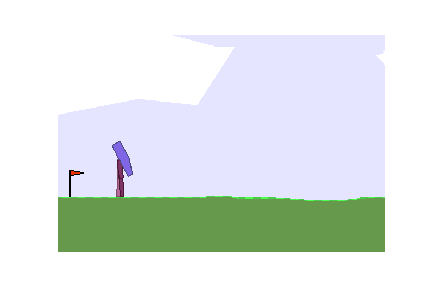
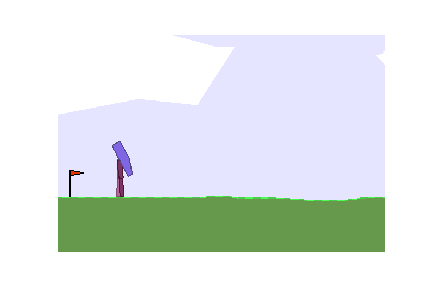
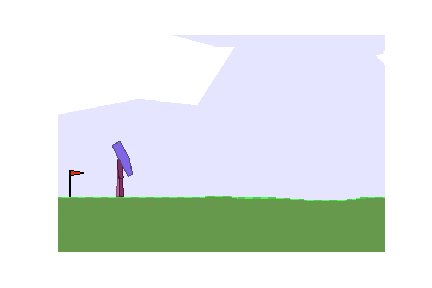
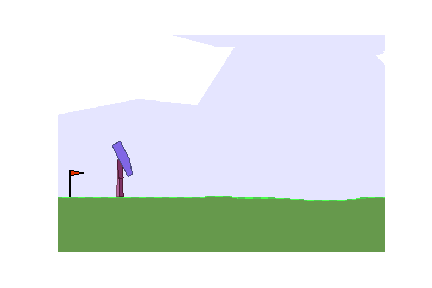
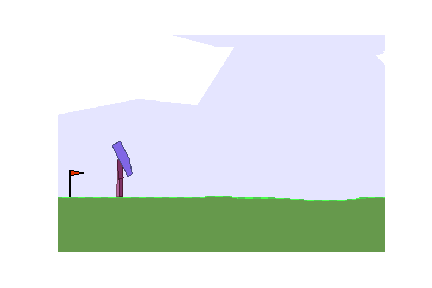
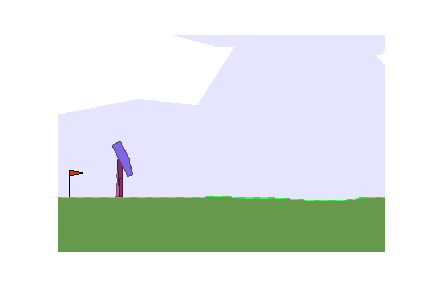
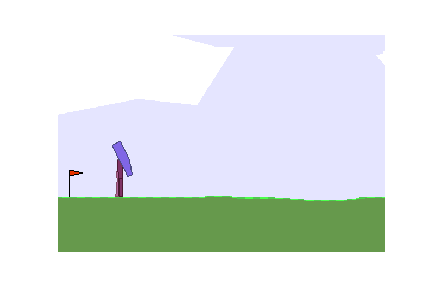
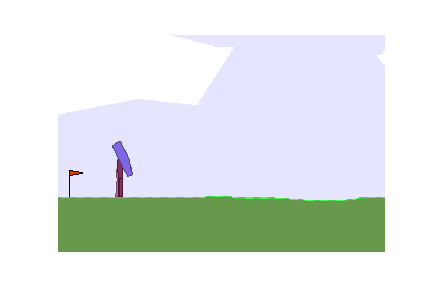
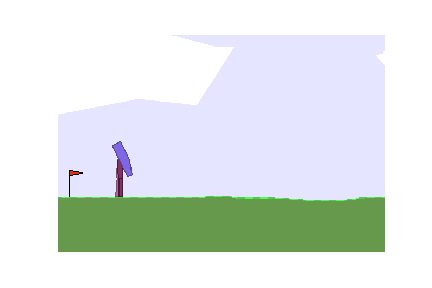
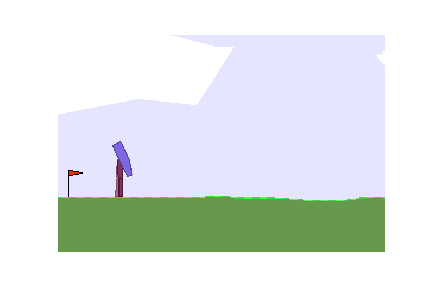
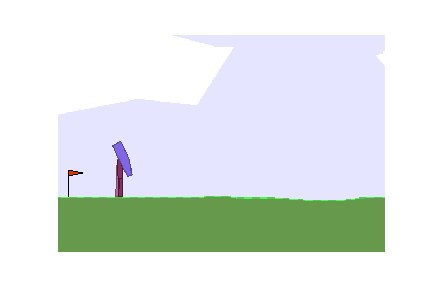
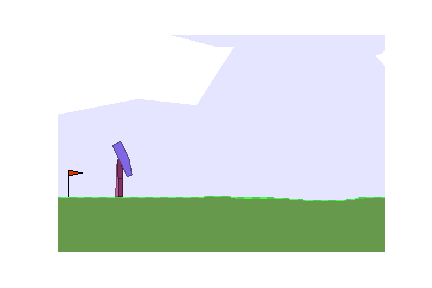
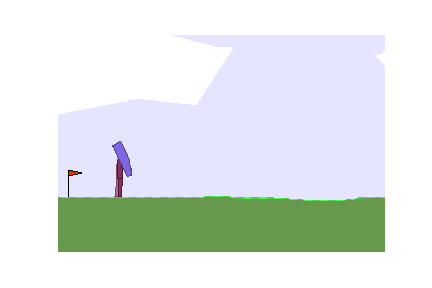
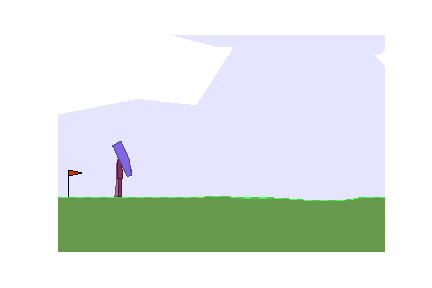
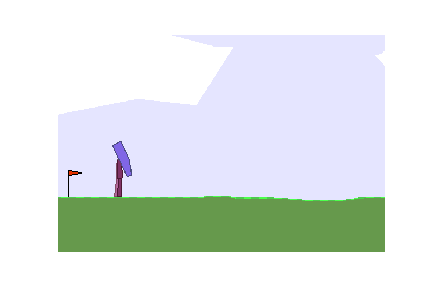
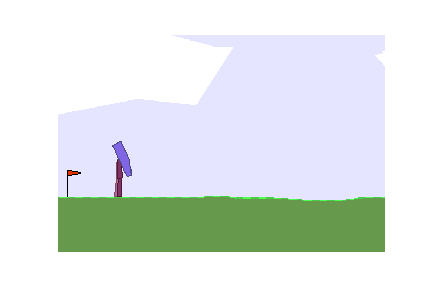
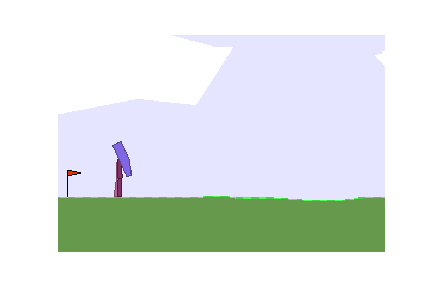
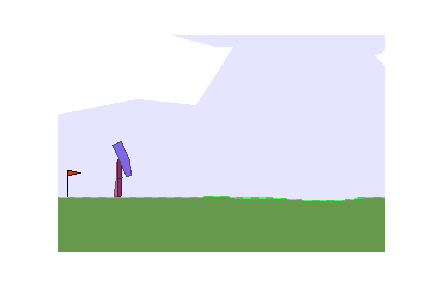
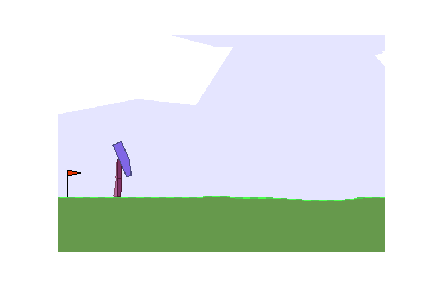
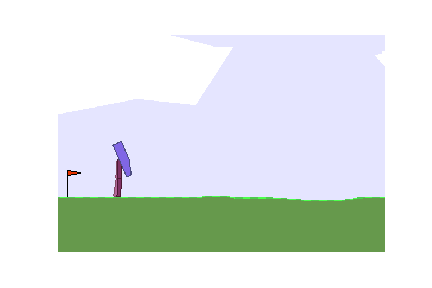
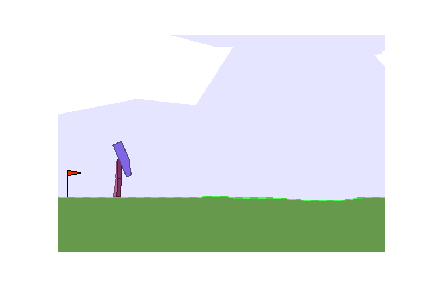
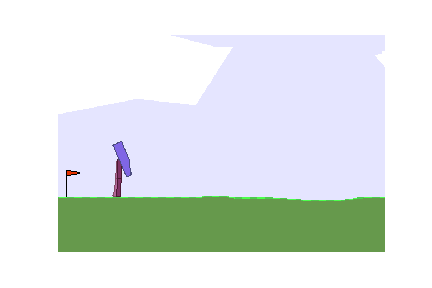
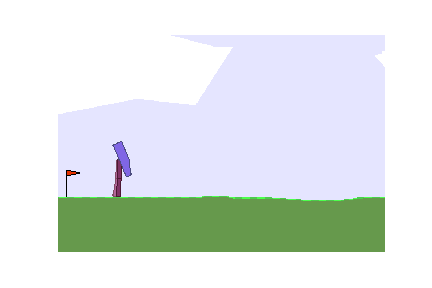
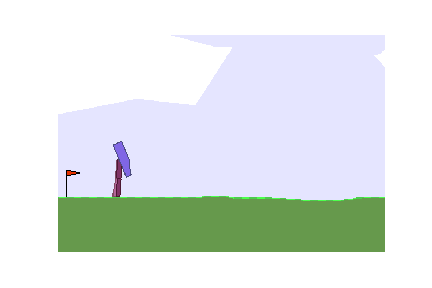
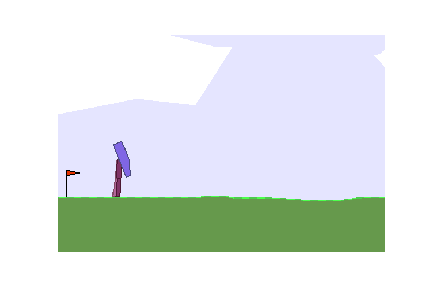
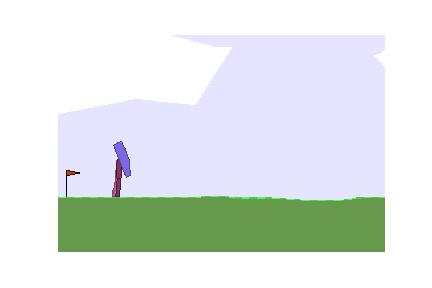
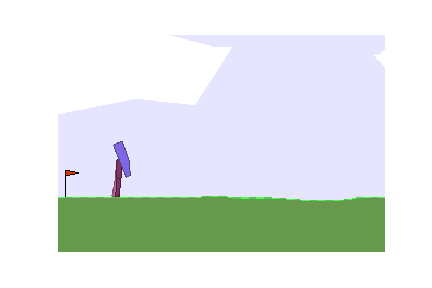
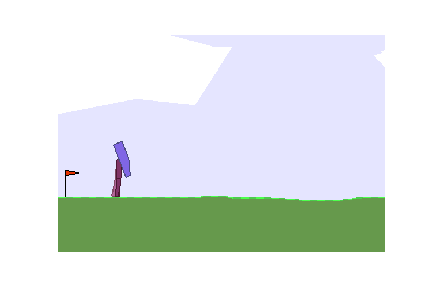
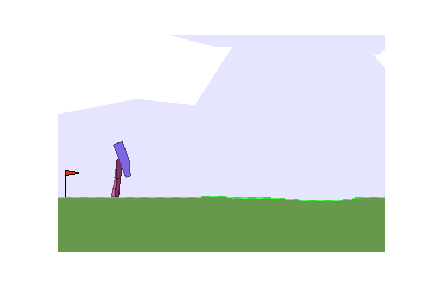
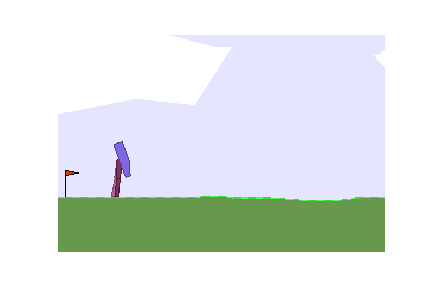
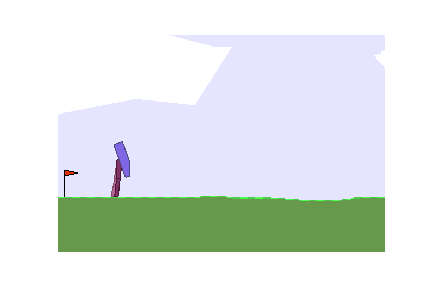
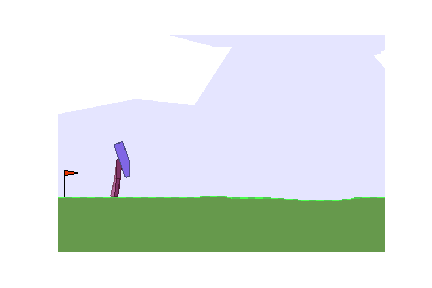
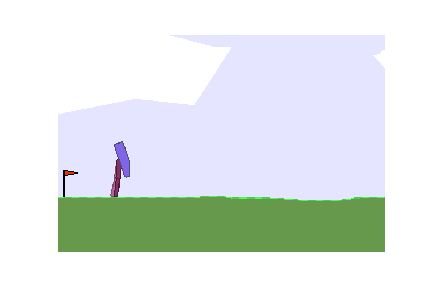
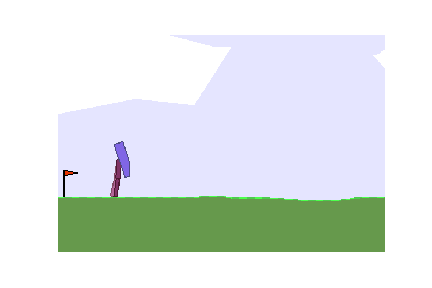
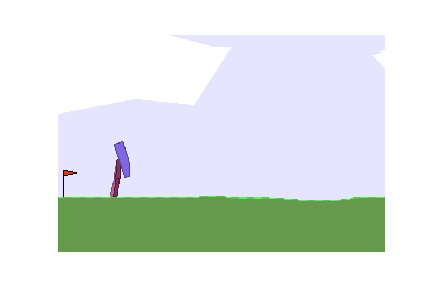
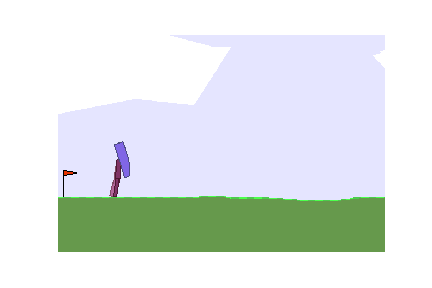
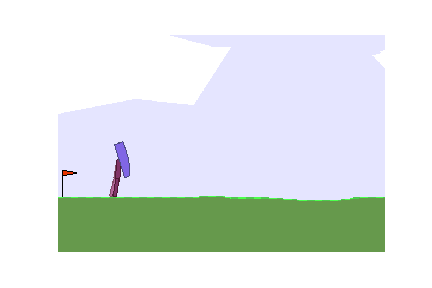
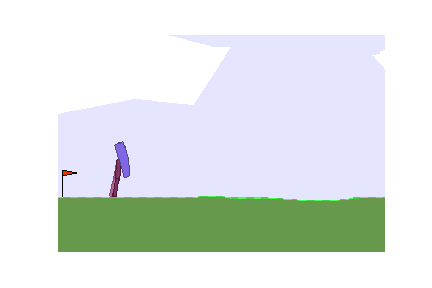
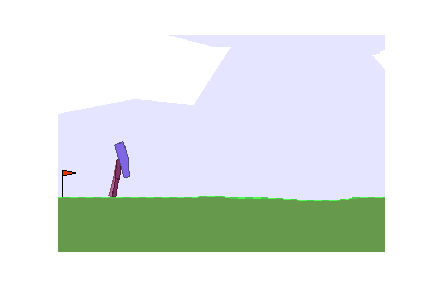
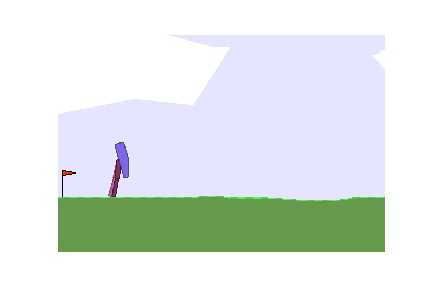
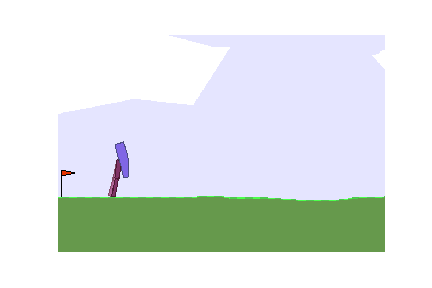
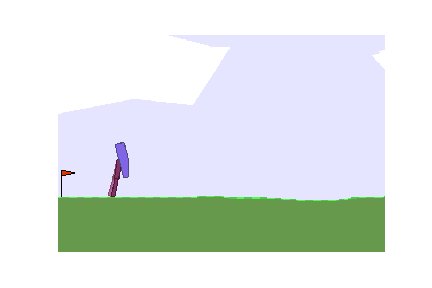
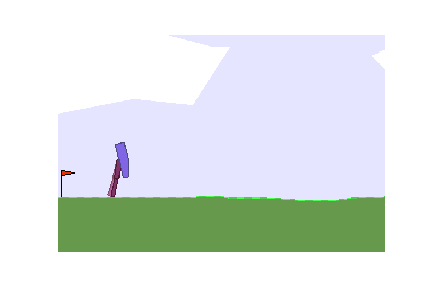
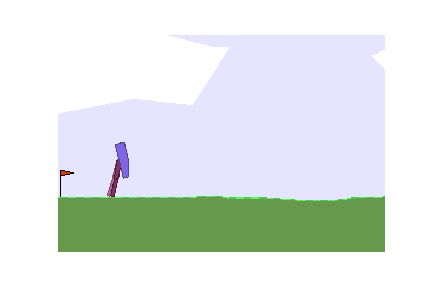
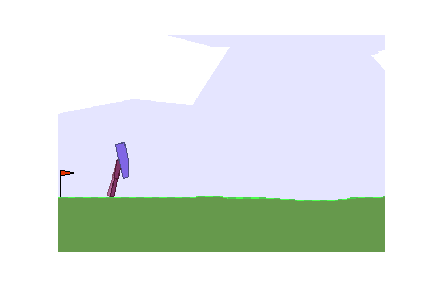
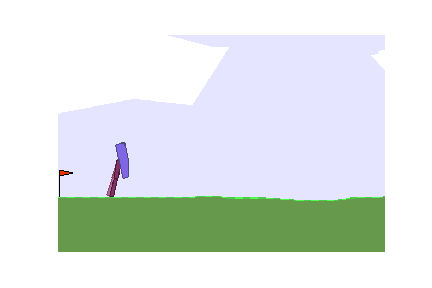
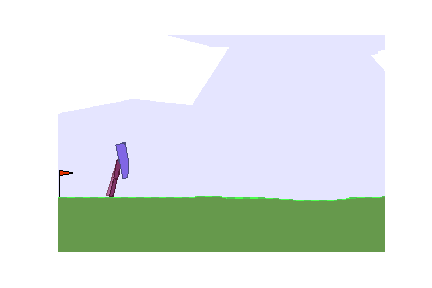
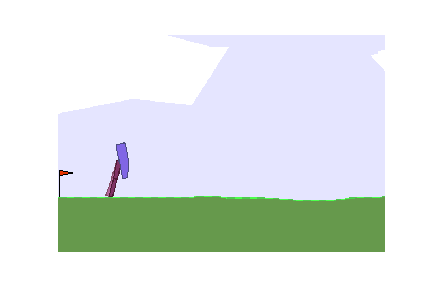
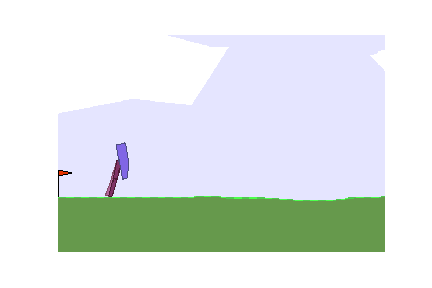
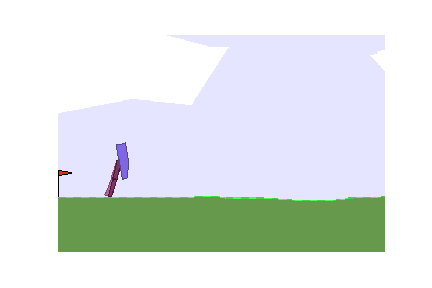
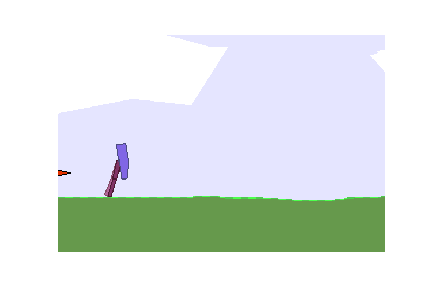
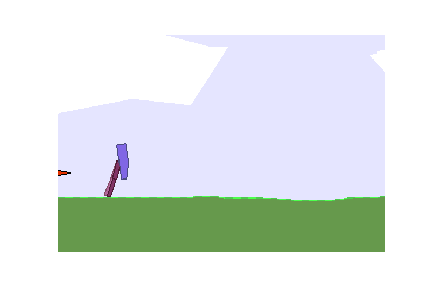
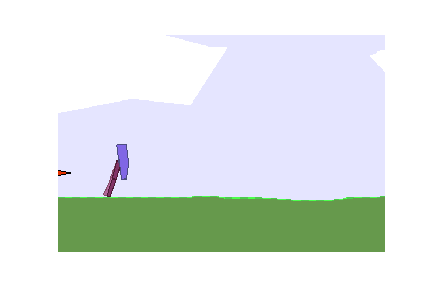
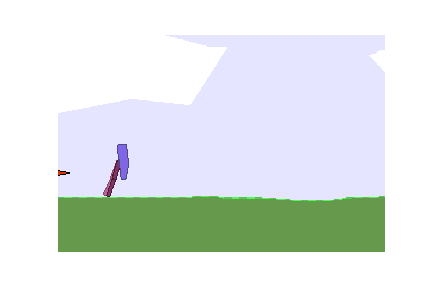
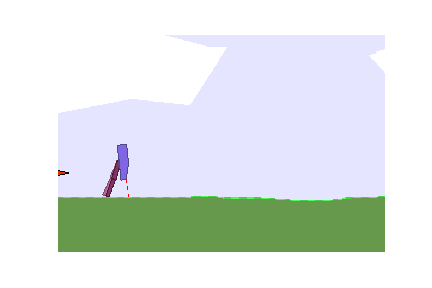
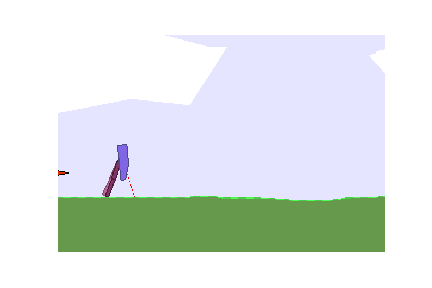
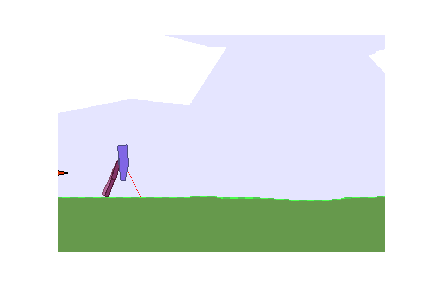
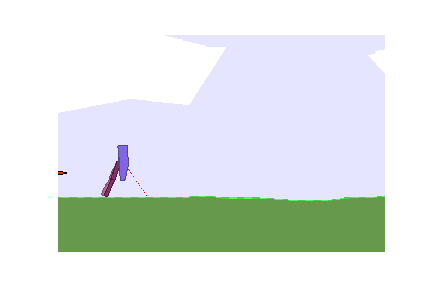
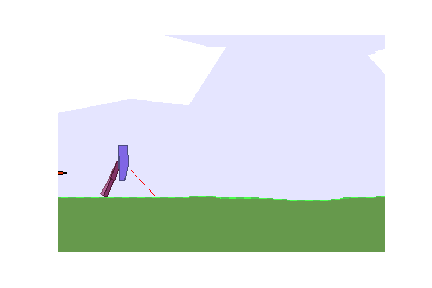
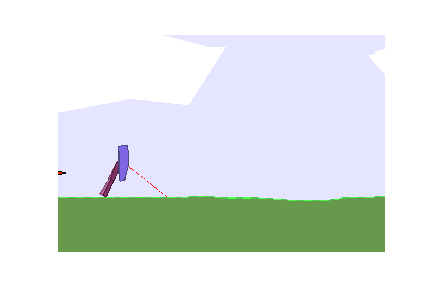
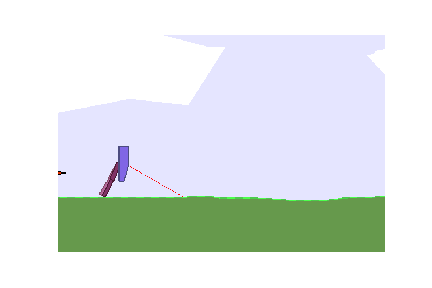
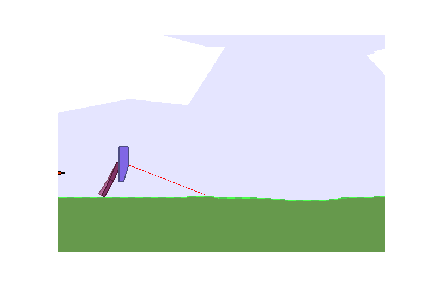
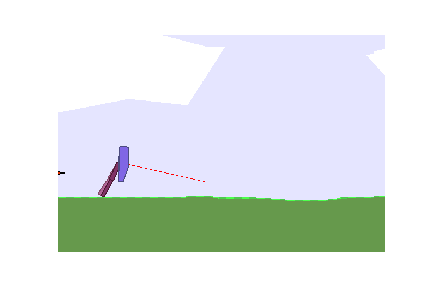
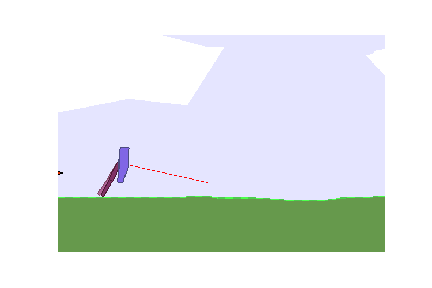
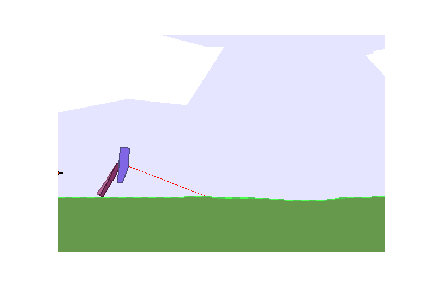
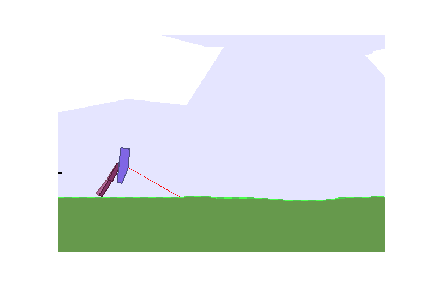
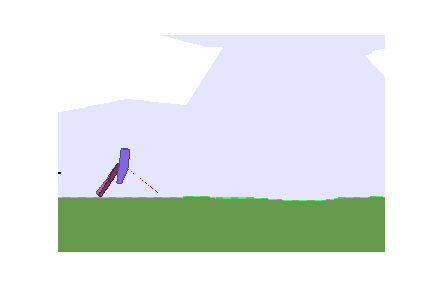
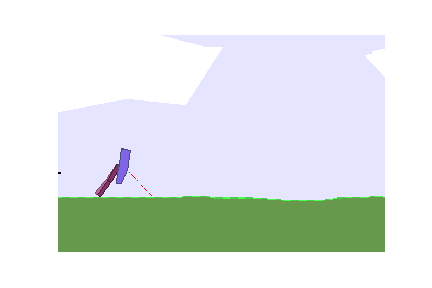
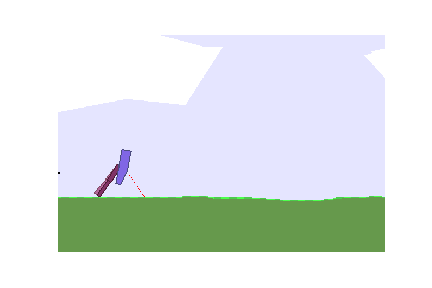
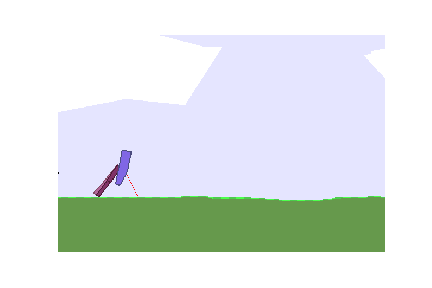
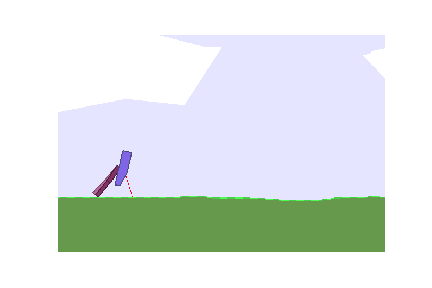
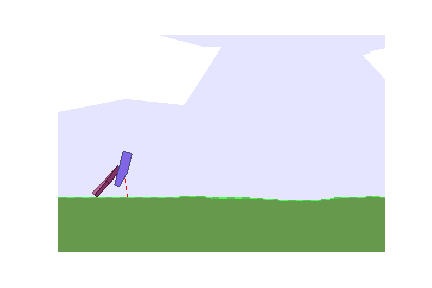
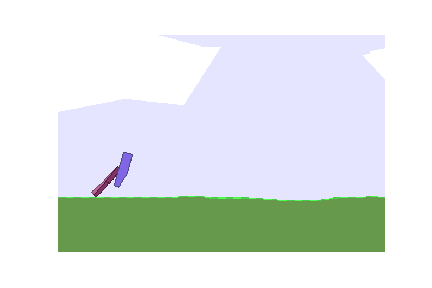
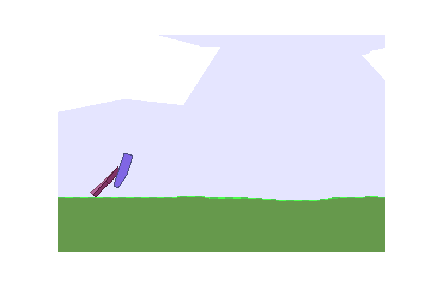
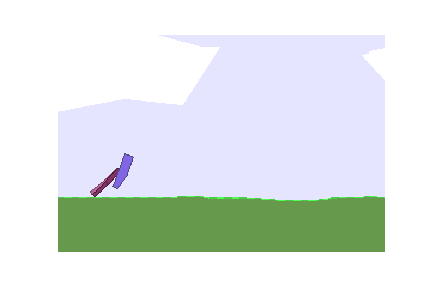
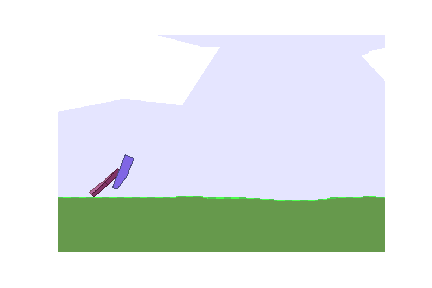
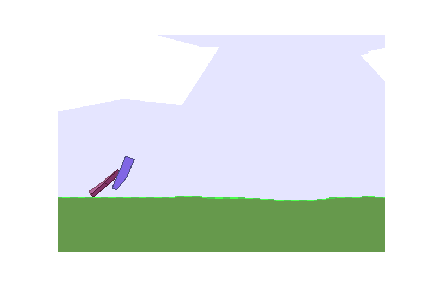
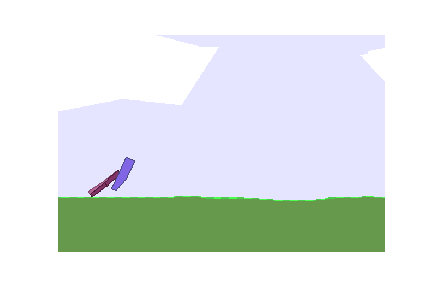
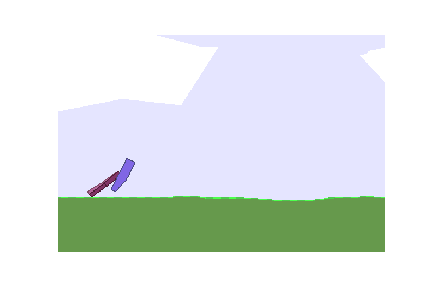
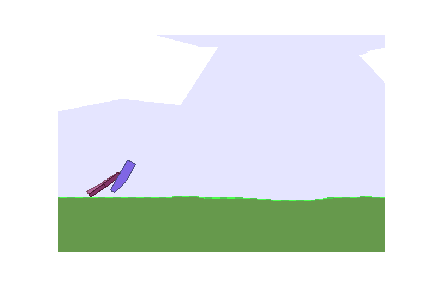
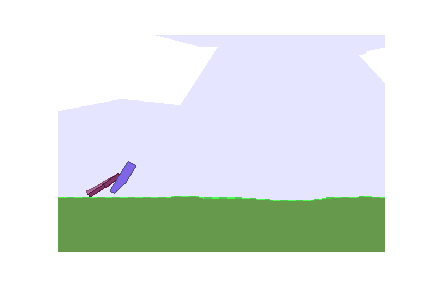
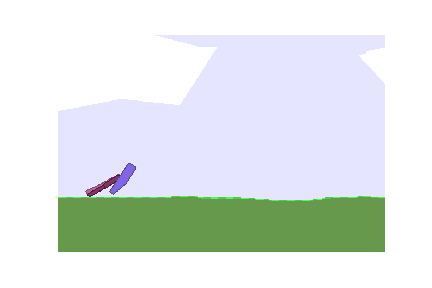
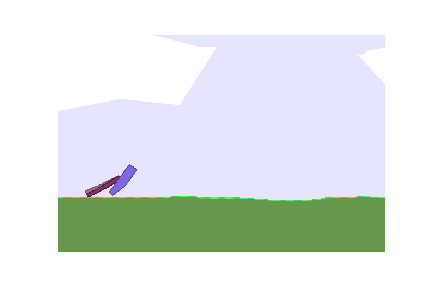
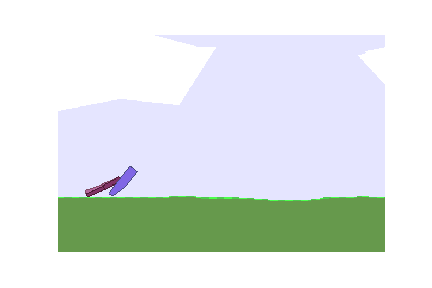
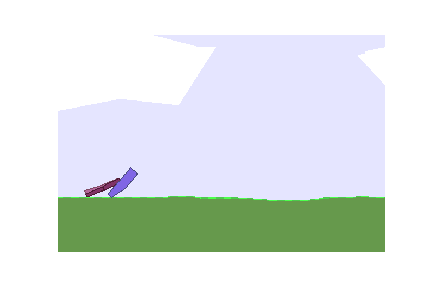

In [20]:
reward, frames = base_pol.playPol(True)
print(f'Total reward: {reward}')
display_frames_as_gif(frames)

## Random Search Over Parameters

In [94]:
class Learner():
    def __init__(self, pol):
        self.pol = pol
        self.num_deltas = 16
        self.noise = 0.03
        self.num_best_deltas = 8
        self.lr = 0.01
        
    def train(self, epochs):
        for epoch in tqdm(range(epochs), position = 0):
            self.train_episode()
    
    def train_episode(self):
        
        deltas = pol.sample_deltas(self.num_deltas)
        
        pos_r = np.array([self.pol.playPol(pol.W + self.noise*deltas[i])[0] for i in range(self.num_deltas)])
        neg_r = np.array([self.pol.playPol(pol.W - self.noise*deltas[i])[0] for i in range(self.num_deltas)])
        
        sigma = (pos_r + neg_r).std()
        
        sort_idx = np.argsort(-np.maximum(pos_r, neg_r))[:self.num_best_deltas]
        
        step = np.array([deltas[i]*(pos_r[i]-neg_r[i]) for i in sort_idx]).sum(axis = 0)
        step = step * self.lr/(sigma * self.num_best_deltas)
        
        pol.W += step

In [104]:
base_pol = Base_Policy()

In [105]:
learn = Learner(base_pol)

In [106]:
learn.train(25)

100%|██████████| 25/25 [00:29<00:00,  1.20s/it]


Total reward: -113.54906178064334



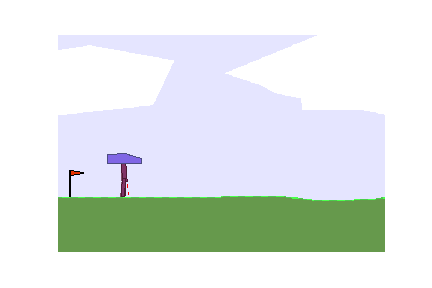
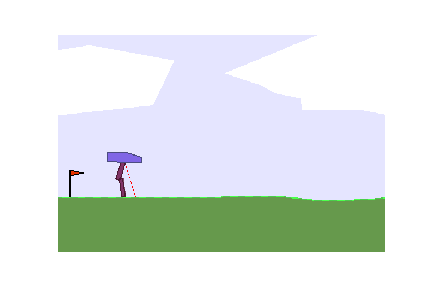
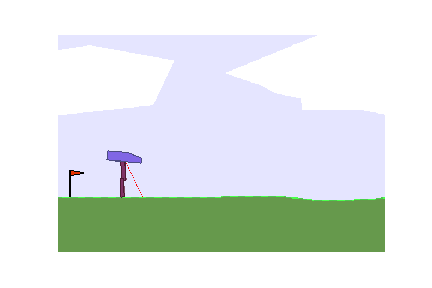
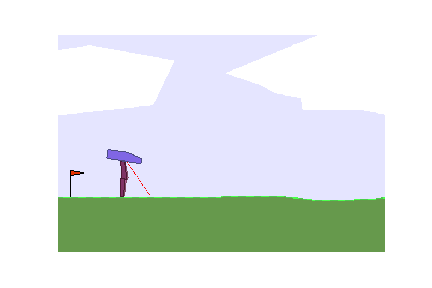
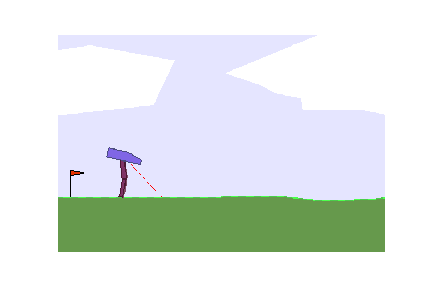
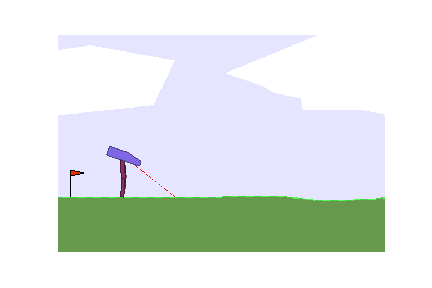
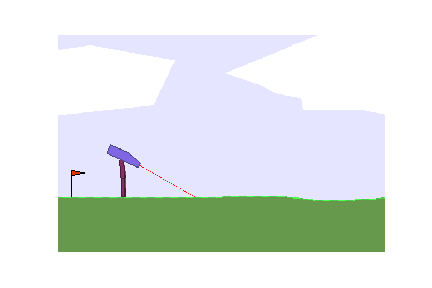
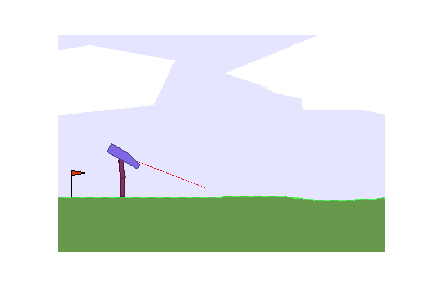
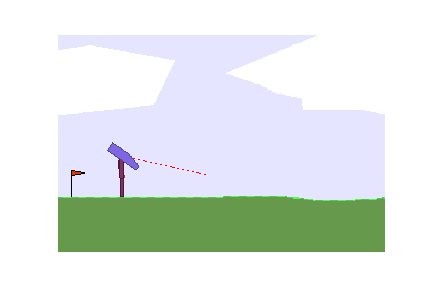
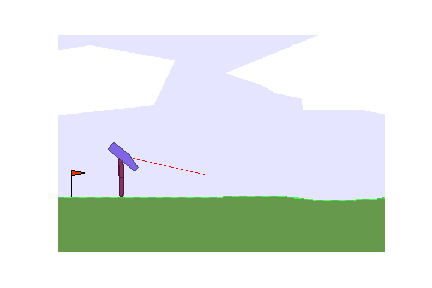
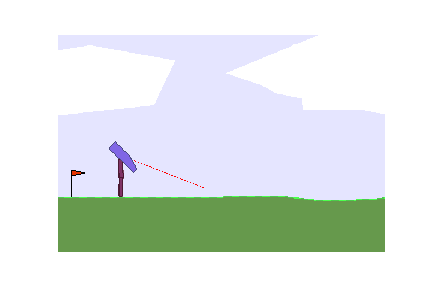
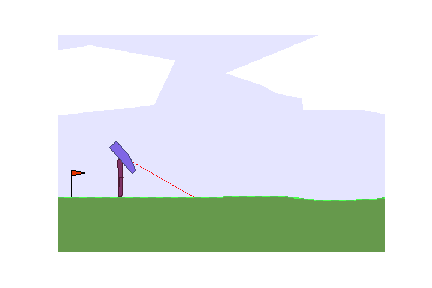
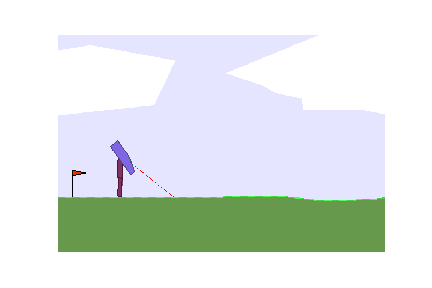
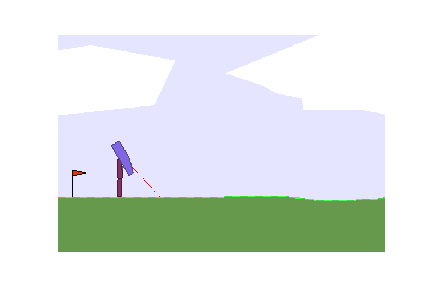
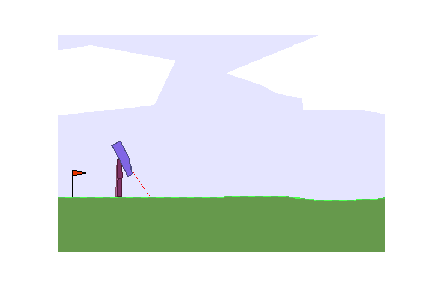
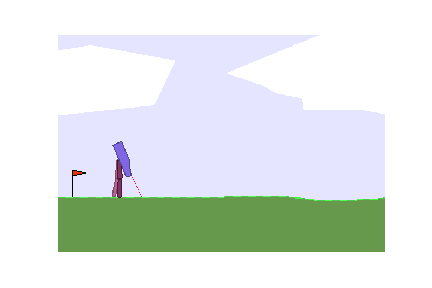
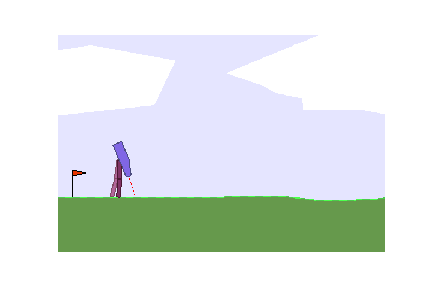
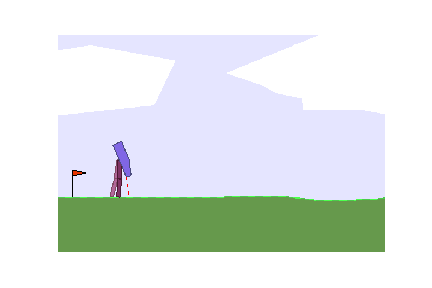
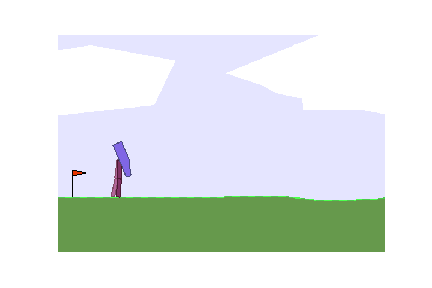
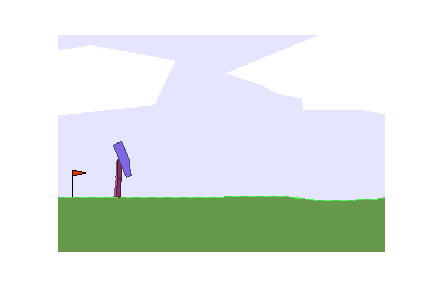
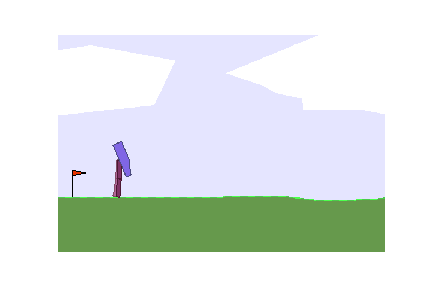
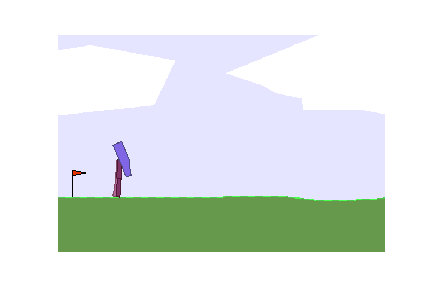
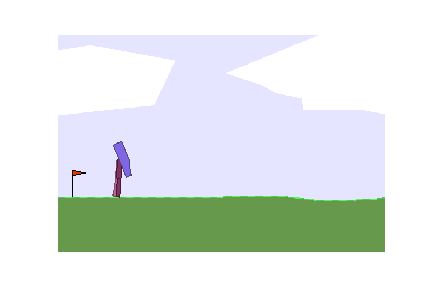
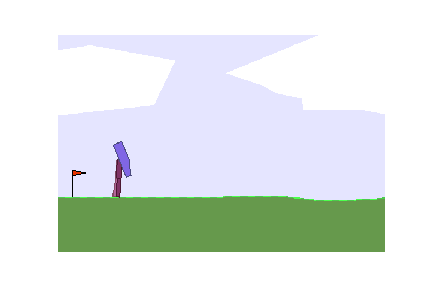
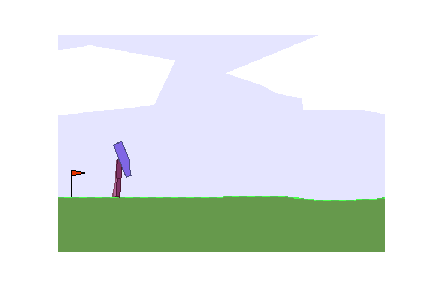
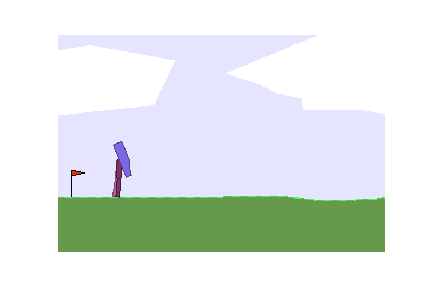
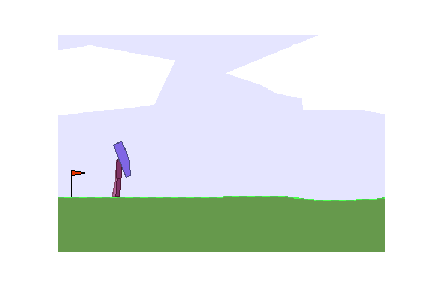
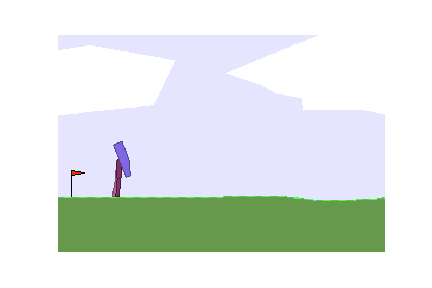
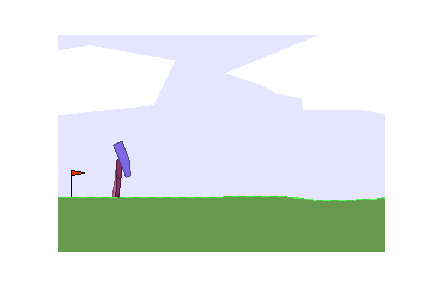
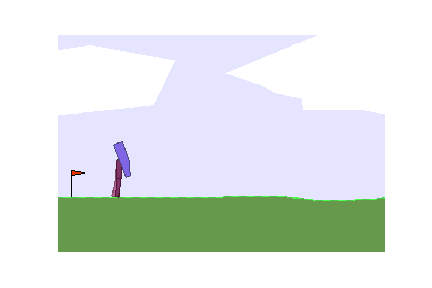
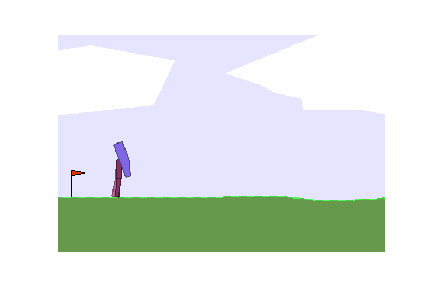
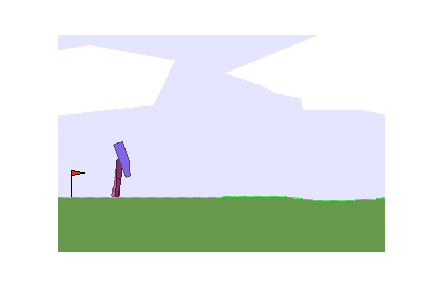
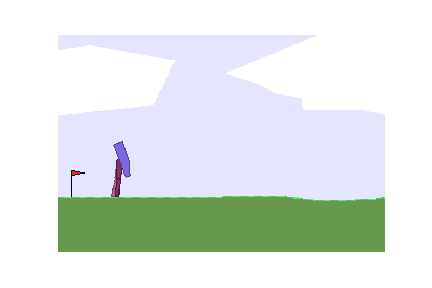
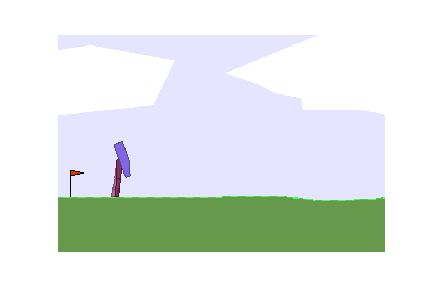
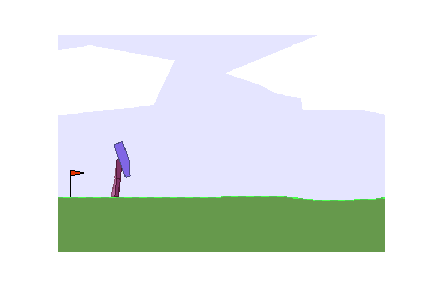
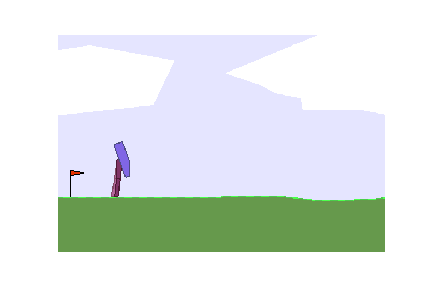
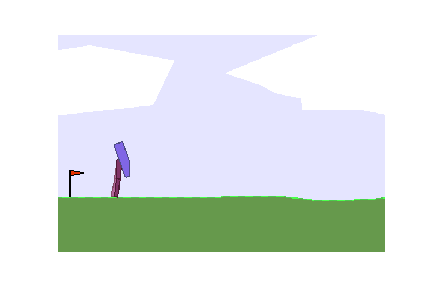
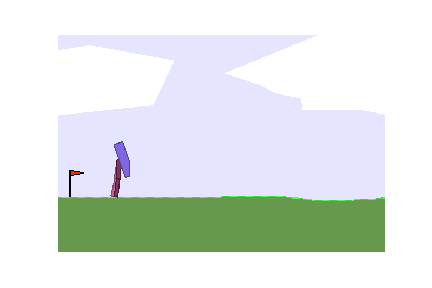
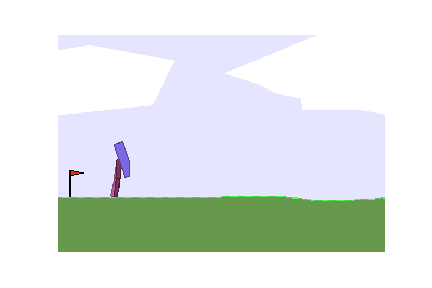
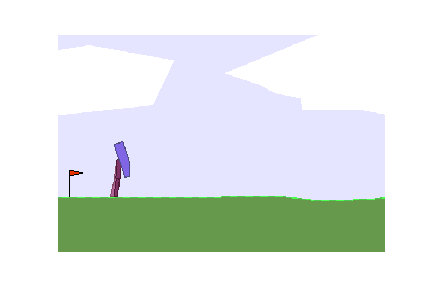
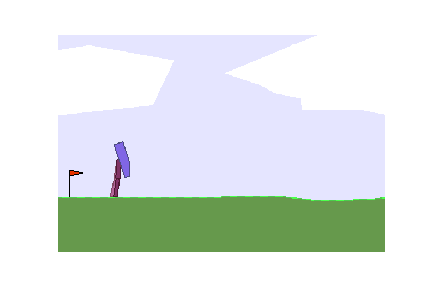
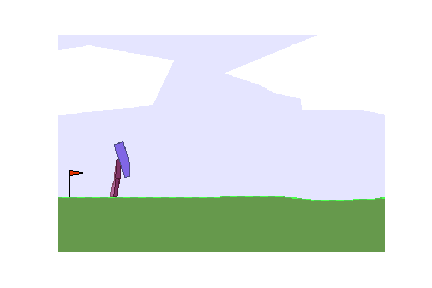
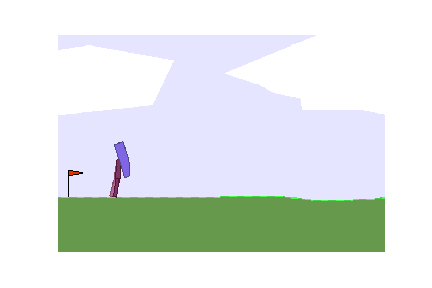
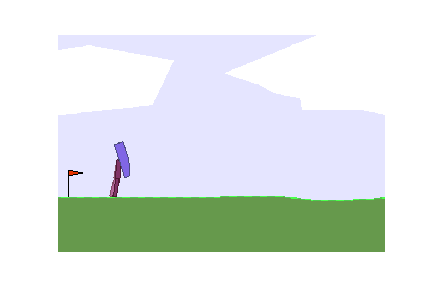
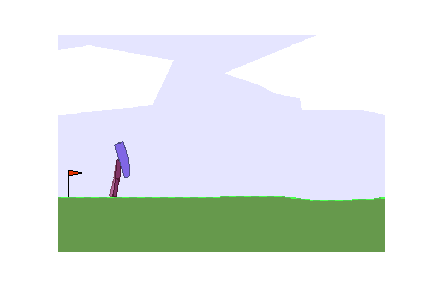
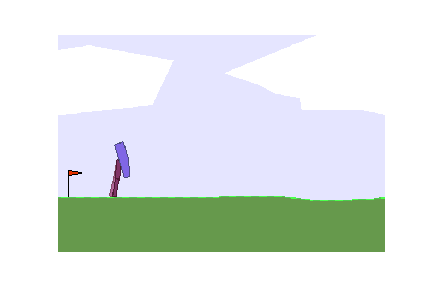
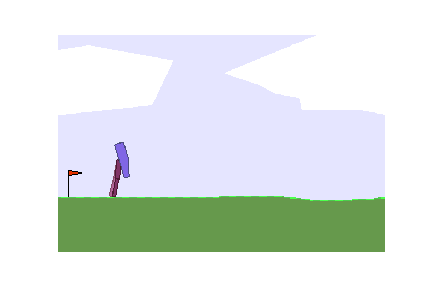
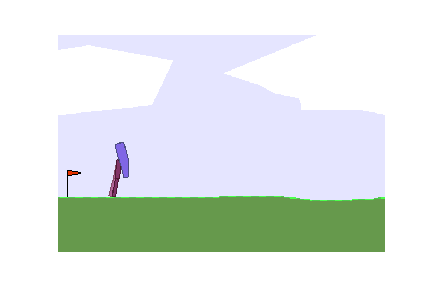
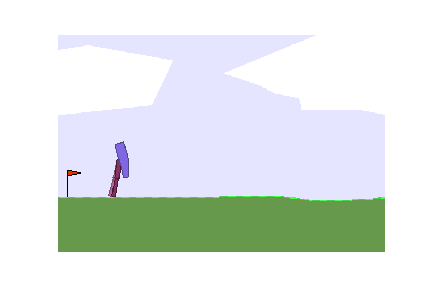
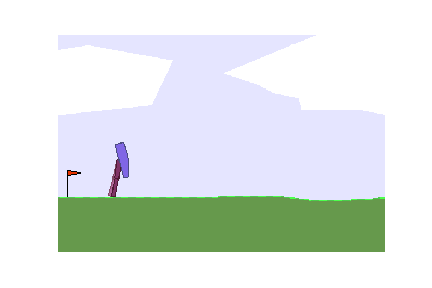
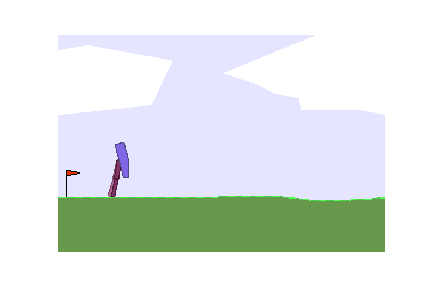
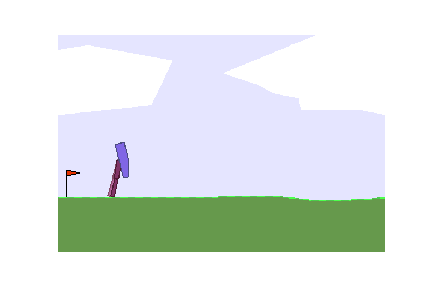
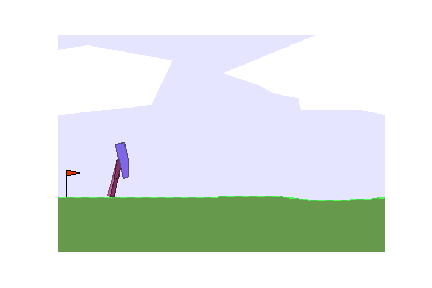
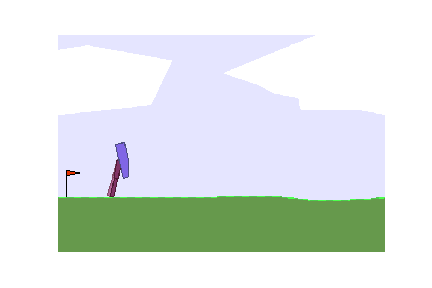
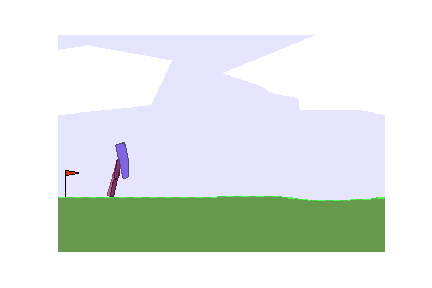
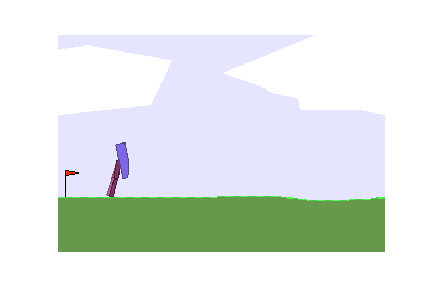
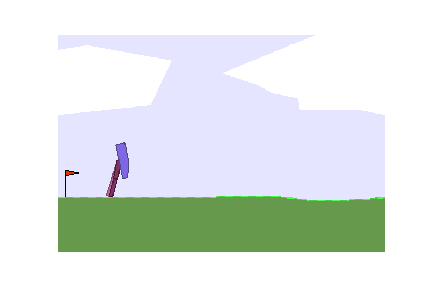
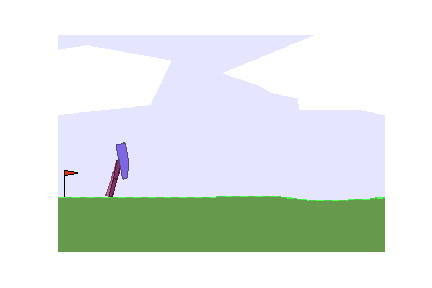
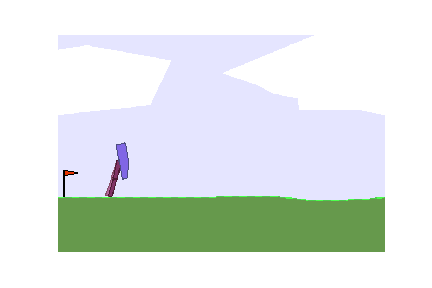
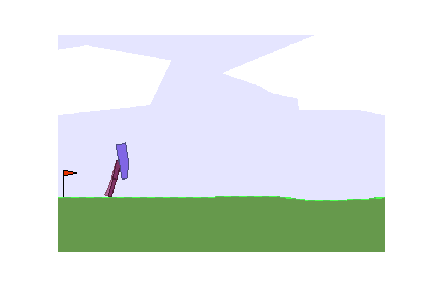
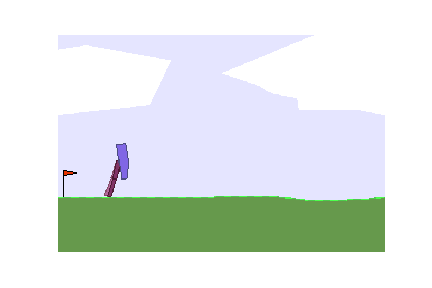
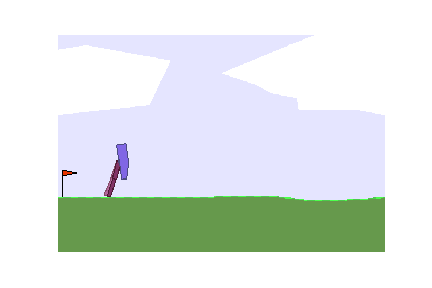
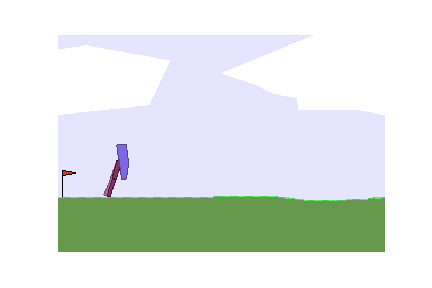
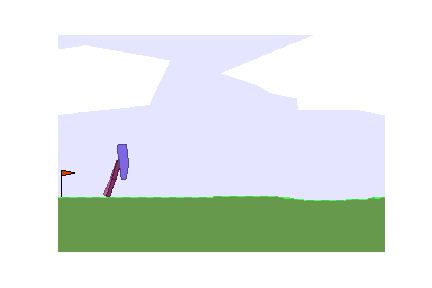
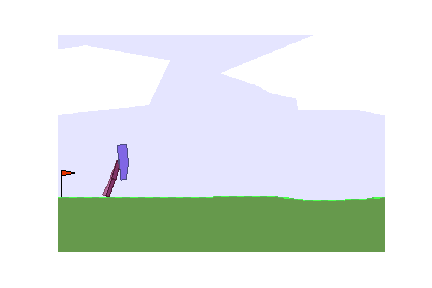
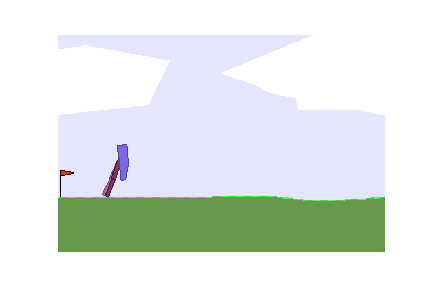
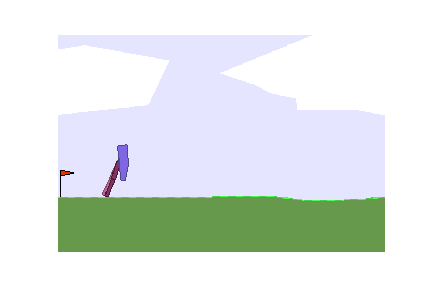
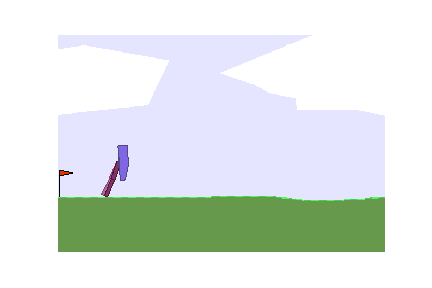
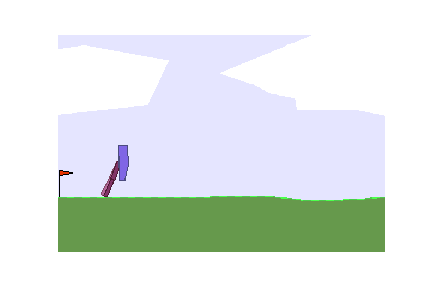
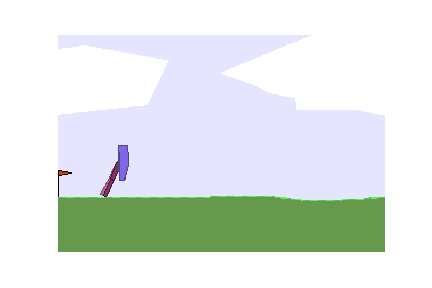
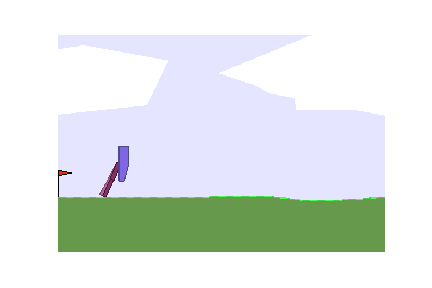
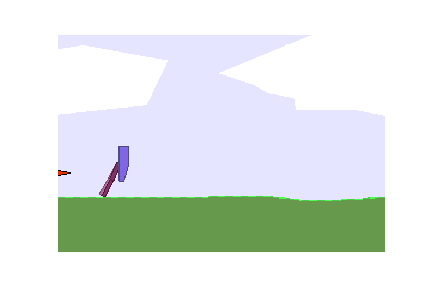
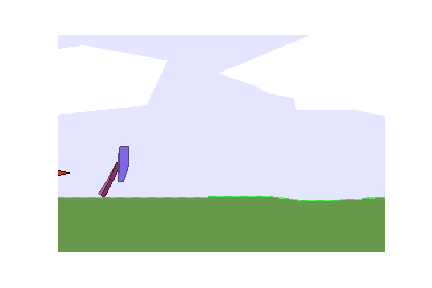
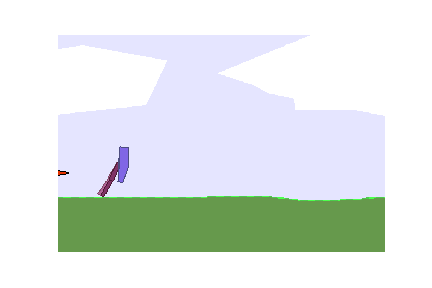
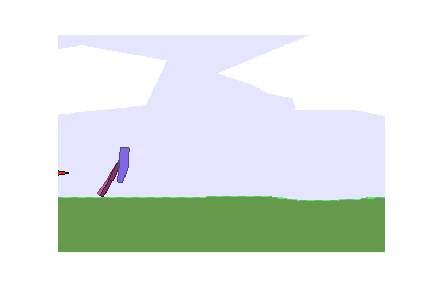
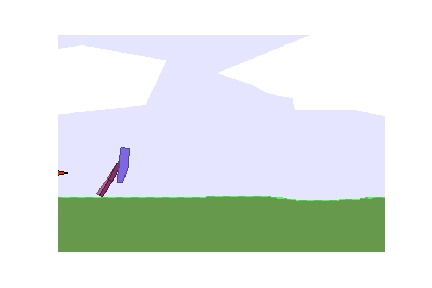
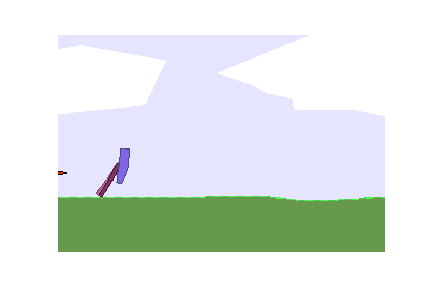
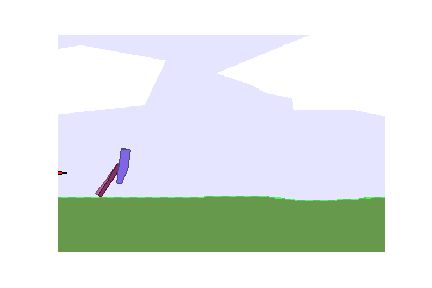
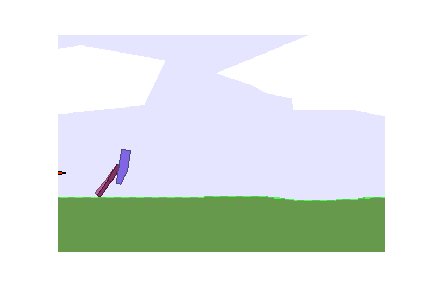
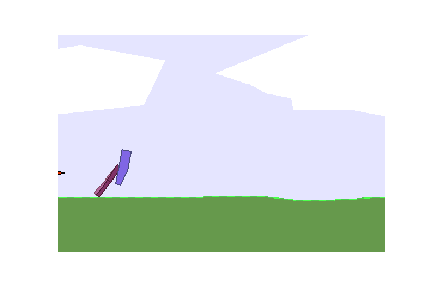
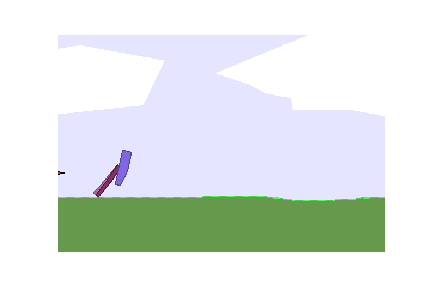
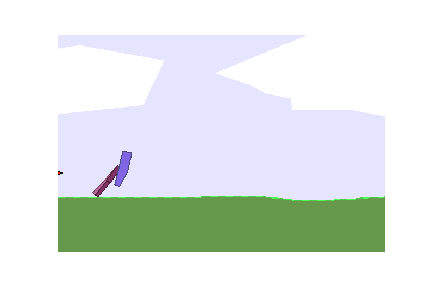
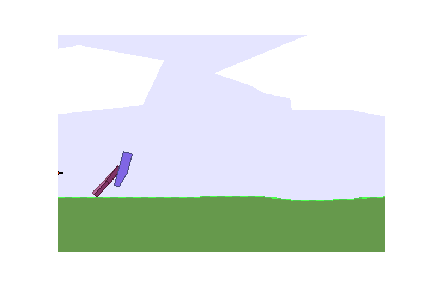
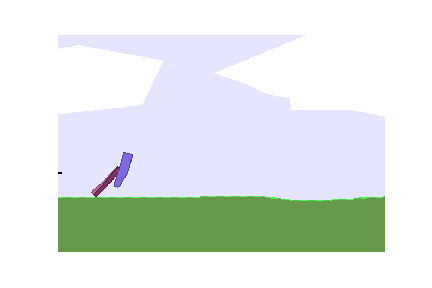
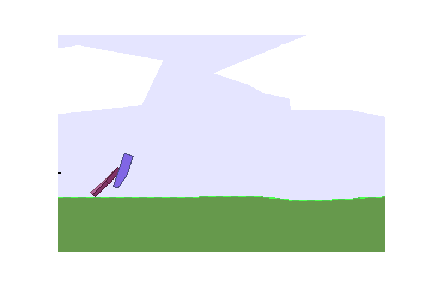
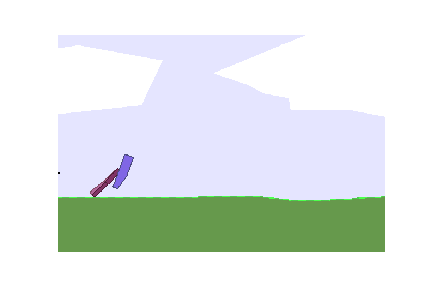
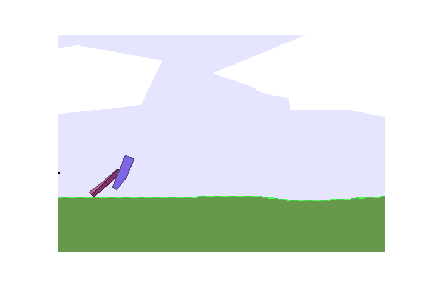
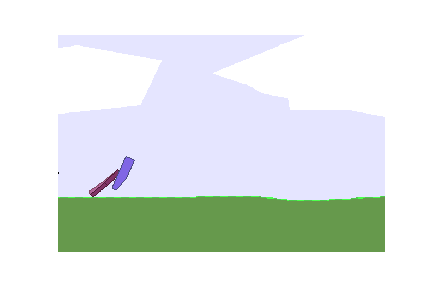
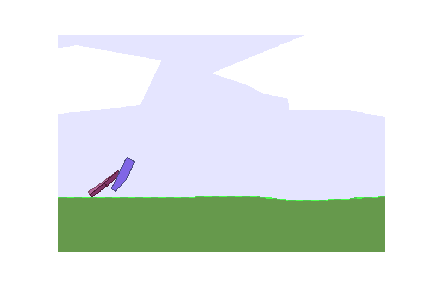
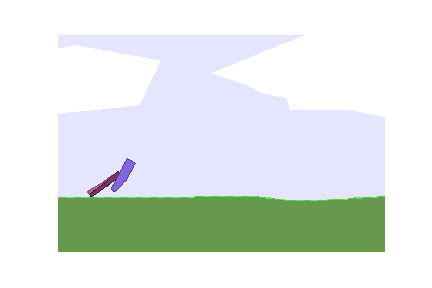
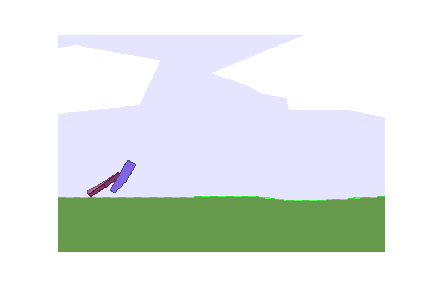
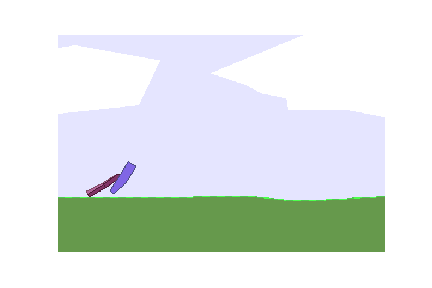
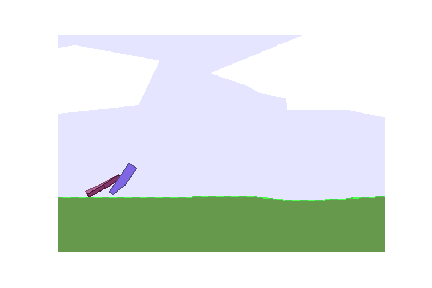
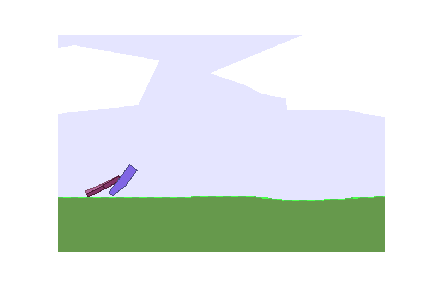
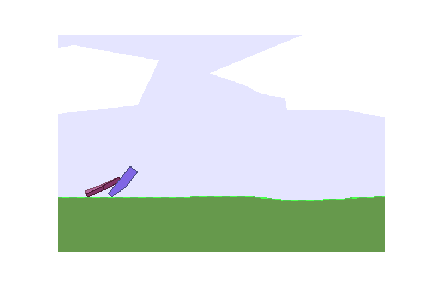

In [113]:
illustrate(base_pol)

## Normalize State

In [156]:
class norm_state_Policy(Base_Policy):
    def __init__(self):
        super().__init__()
        self.inp_mean, self.inp_var = np.zeros(self.nS), np.ones(self.nS)
        self.mean_diff = np.zeros(self.nS)
        
    def call_before_action(self):
        self.update_stats()
        print(self.inp_mean)
        print(self.inp_var)
        print(self.s)
        self.normalize_state()
        print(self.s)
        
    def update_stats(self):
        last_mean = self.inp_mean.copy()
        self.inp_mean += (self.s - self.inp_mean) / self.n
        self.mean_diff += (self.s - last_mean) * (self.s - self.inp_mean)
        self.inp_var = np.clip((self.mean_diff / self.n), a_min = 1e-2, a_max = None)
        
    def normalize_state(self):
        self.s = (self.s - self.inp_mean) / self.inp_var

In [157]:
norm_pol = norm_state_Policy()

In [158]:
learn = Learner(norm_pol)

In [159]:
norm_pol.n

0

In [160]:
learn.train(25)

  0%|          | 0/25 [00:00<?, ?it/s]/home/krisztian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide



[ inf  inf -inf -inf  inf  inf  inf -inf  inf  inf  inf  inf -inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf]
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[ 2.74573546e-03  1.10199361e-05 -1.43697482e-03 -1.60000706e-02
  9.25039351e-02  3.33585986e-03  8.59774202e-01 -1.24965554e-03
  1.00000000e+00  3.28161679e-02  3.33570549e-03  8.53526637e-01
 -2.26975403e-03  1.00000000e+00  4.40813392e-01  4.45819497e-01
  4.61422116e-01  4.89549488e-01  5.34102023e-01  6.02460206e-01
  7.09147871e-01  8.85930538e-01  1.00000000e+00  1.00000000e+00]
[-inf -inf  inf  inf -inf -inf -inf  inf -inf -inf -inf -inf  inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]


AssertionError: r.LengthSquared() > 0.0f